In [1]:
import pickle 
import numpy as np
import pandas as pd
import pathlib 
import os, sys
import torch 
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from torch.nn import functional as F
import scipy.linalg
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%matplotlib widget

LABEL = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']
with open('/home/kitadam/ENR_Sven/moxie/data/processed/pedestal_profiles_ML_READY_ak_19042022.pickle', 'rb') as file:
    massive_dict = pickle.load(file)
    full_dict = massive_dict['ALL']
    massive_dict = {}
    train_X, train_y, train_mask, train_radii, train_real_space_radii, train_ids = full_dict['train_dict']['padded']['profiles'],full_dict['train_dict']['padded']['controls'], full_dict['train_dict']['padded']['masks'], full_dict['train_dict']['padded']['radii'] ,full_dict['train_dict']['padded']['real_space_radii'] , full_dict['train_dict']['padded']['pulse_time_ids'] 
    val_X, val_y, val_mask, val_radii, val_real_space_radii, val_ids = full_dict['val_dict']['padded']['profiles'],full_dict['val_dict']['padded']['controls'], full_dict['val_dict']['padded']['masks'], full_dict['val_dict']['padded']['radii'], full_dict['val_dict']['padded']['real_space_radii'], full_dict['val_dict']['padded']['pulse_time_ids']
    test_X, test_y, test_mask, test_radii, test_real_space_radii, test_ids = full_dict['test_dict']['padded']['profiles'],full_dict['test_dict']['padded']['controls'], full_dict['test_dict']['padded']['masks'], full_dict['test_dict']['padded']['radii'], full_dict['test_dict']['padded']['real_space_radii'], full_dict['test_dict']['padded']['pulse_time_ids']

train_pulse_order = [int(x.split('/')[0]) for x in train_ids]
train_pulses = list(set(train_pulse_order))
train_pulse_ids = [[index for index in range(len(train_pulse_order)) if train_pulse_order[index] == pulse] for pulse in train_pulses]

val_pulse_order = [int(x.split('/')[0]) for x in val_ids]
val_pulses = list(set(val_pulse_order))
val_pulse_ids = [[index for index in range(len(val_pulse_order)) if val_pulse_order[index] == pulse] for pulse in val_pulses]

test_pulse_order = [int(x.split('/')[0]) for x in test_ids]
test_pulses = list(set(test_pulse_order))
test_pulse_ids = [[index for index in range(len(test_pulse_order)) if test_pulse_order[index] == pulse] for pulse in test_pulses]

machine_param_order = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']
jet_pedestal_database = pd.read_csv('/home/kitadam/ENR_Sven/moxie/data/processed/jet-pedestal-database.csv')
jet_pedestal_database = jet_pedestal_database[(jet_pedestal_database['FLAG:HRTSdatavalidated'] > 0) & (jet_pedestal_database['FLAG:DEUTERIUM'] == 1)]
relevant_columns = ['shot', 'nepedheight10^19(m^-3)','Tepedheight(keV)', 'B(T)','Ip(MA)', 'q95',  'R(m)', 'a(m)','gasflowrateofmainspecies10^22(e/s)',  'P_TOT=PNBI+Pohm+PICRH-Pshi(MW)', 'P_ICRH(MW)', 'P_NBI(MW)','plasmavolume(m^3)', 'averagetriangularity', 'divertorconfiguration', 'FLAG:Seeding', 'FLAG:Kicks',
 'FLAG:RMP',
 'FLAG:pellets',]
FLAGS = [x for x in jet_pedestal_database.columns.to_list() if 'FLAG' in x]

In [21]:
# Load a model
from moxie.models.DIVA_ak_1 import DIVAMODEL
from moxie.data.profile_lightning_module import PLDATAMODULE_AK
from moxie.experiments.DIVA_EXP_AK_1 import EXAMPLE_DIVA_EXP_AK

import pytorch_lightning as pl 
model_hyperparams = {'in_ch': 2, 'out_length':19,
                    'mach_latent_dim': 10, 'stoch_latent_dim': 3,
                    'beta_stoch': 8.350, 'beta_mach_unsup':  0.06,'beta_mach_sup':  0.0,
                    'alpha_mach': 42.0, 'alpha_prof': 289.0,  
                    'start_sup_time': 1330,
                     'physics': True, 'gamma_stored_energy': 2.0,
                    'mp_hdims_aux': [263, 469, 284], 'mp_hdims_cond':[20, 136, 54, 205, 154, 408],
                    'hidden_dims': [2, 4], 'loss_type': 'semi-supervised',}
model = DIVAMODEL(**model_hyperparams)

state_dict = torch.load('./model_results/modelstatedict_no_physics_decent.pth')
model.load_state_dict(state_dict['model'])


<All keys matched successfully>

In [23]:
# Helper Functions
def de_standardize(x, mu, var): 
    return (x*var) + mu

def standardize(x, mu, var): 
    return (x - mu) / var
# Get norms from dataset
MP_norm, MP_var = state_dict['MP_norms']
norms_MP = MP_norm, MP_var
D_norm, D_var = state_dict['D_norms']
norms_D = D_norm, D_var
T_norm, T_var = state_dict['T_norms']
norms_T = T_norm, T_var

# Prepare some data 
train_mp_tensors = torch.tensor(train_y).float()
val_mp_tensors = torch.tensor(val_y).float()
test_mp_tensors = torch.tensor(test_y).float()

train_mp_normalized = standardize(train_mp_tensors, MP_norm, MP_var)
val_mp_normalized = standardize(val_mp_tensors, MP_norm, MP_var)
test_mp_normalized = standardize(test_mp_tensors, MP_norm, MP_var)

train_profiles = torch.tensor(train_X).float()
val_profiles = torch.tensor(val_X).float()
test_profiles = torch.tensor(test_X).float()

train_profiles_normalized = torch.clone(train_profiles).float()
train_profiles_normalized[:, 0] = standardize(train_profiles_normalized[:, 0], D_norm, D_var)
train_profiles_normalized[:, 1] = standardize(train_profiles_normalized[:, 1], T_norm, T_var)


test_profiles_normalized = torch.clone(test_profiles).float()
test_profiles_normalized[:, 0] = standardize(test_profiles_normalized[:, 0], D_norm, D_var)
test_profiles_normalized[:, 1] = standardize(test_profiles_normalized[:, 1], T_norm, T_var)

In [19]:
LABEL = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']

In [35]:
train_mp_tensors[0]

tensor([ 3.4958e+00,  2.9270e+00,  9.1401e-01,  7.5272e+01,  4.3649e-01,
         4.0161e-01,  1.7330e+00,  4.9691e+05, -2.4839e+06, -2.6569e+00,
         1.4093e+07,  2.0134e+06,  2.6947e+22])

In [2]:
def line_integral(gamma, elongation, minor_radius): 
    b = elongation*minor_radius 
    alpha = -gamma/(b*b)
    # print(b, alpha)
    return (np.arcsinh(2*abs(alpha)*b) + 2*abs(alpha)*b*np.sqrt(4*alpha*alpha*b*b+a)) / (2*abs(alpha))
    # return (np.sqrt(alpha)*np.arcsinh(2*np.sqrt(alpha)*b) + 2*alpha*b*np.sqrt(4*alpha*b*b+1))/(2*alpha)

def numpy_shaping_approx(minor_radius, tri_u, tri_l, elongation):
    triangularity = (tri_u + tri_l) / 2.0
    b = elongation*minor_radius
    gamma_top = -(minor_radius + triangularity)
    gamma_bot = minor_radius - triangularity
    alpha_top = -gamma_top / (b*b)
    alpha_bot = -gamma_bot / (b*b)
    top_int = (np.arcsinh(2*np.abs(alpha_top)*b) + 2*np.abs(alpha_top)*b*np.sqrt(4*alpha_top*alpha_top*b*b+1)) / (2*np.abs(alpha_top))
    bot_int = (np.arcsinh(2*np.abs(alpha_bot)*b) + 2*np.abs(alpha_bot)*b*np.sqrt(4*alpha_bot*alpha_bot*b*b+1)) / (2*np.abs(alpha_bot))
    return bot_int + top_int 

def np_bpol_approx(minor_radius, tri_u, tri_l, elongation, current): 
    shaping = numpy_shaping_approx(minor_radius, tri_u, tri_l, elongation)
    return mu_0*current/shaping
def torch_shaping_approx(minor_radius, tri_u, tri_l, elongation):
    triangularity = (tri_u + tri_l) / 2.0
    b = elongation*minor_radius
    gamma_top = -(minor_radius + triangularity)
    gamma_bot = minor_radius - triangularity
    alpha_top = -gamma_top / (b*b)
    alpha_bot = -gamma_bot / (b*b)
    top_int = (torch.arcsinh(2*torch.abs(alpha_top)*b) + 2*torch.abs(alpha_top)*b*np.sqrt(4*alpha_top*alpha_top*b*b+1)) / (2*torch.abs(alpha_top))
    bot_int = (torch.arcsinh(2*torch.abs(alpha_bot)*b) + 2*torch.abs(alpha_bot)*b*np.sqrt(4*alpha_bot*alpha_bot*b*b+1)) / (2*torch.abs(alpha_bot))
    return bot_int + top_int 


def bpol_approx(mp_tensors): 
    shaping = torch_shaping_approx(mp_tensors[:, 2], mp_tensors[:, 4], mp_tensors[:, 5], mp_tensors[:, 6])
    return mu_0*mp_tensors[:, 8] / shaping

def beta_approximation(profiles_tensors, mp_tensors):
    density, temperature = profiles_tensors[:, 0, :], profiles_tensors[:, 1, :]
    pressure_prof = density*temperature
    pressure_average = pressure_prof[:, 0]     
    bpol = bpol_approx(mp_tensors)
    bt = mp_tensors[:, 9]
    return 2*e_c*2*mu_0 * pressure_average / (bt*bt + bpol*bpol)

e_c = 1.602e-19
mu_0 = 1.256e-6 
triangularity = 0.4187
a = 0.914
elon = 1.73

print(np_bpol_approx(minor_radius=0.57, tri_u=0.54, tri_l=0.54, elongation=1.97, current=8.7e6))


# line_integral_1 = line_integral(gamma_1, elon, a)
# line_integral_2 = line_integral(gamma_2, elon, a)
# total_div = line_integral_1 + line_integral_2


# print(total_div, line_integral_2, line_integral_1)
# print(torch_shaping_approx(train_mp_tensors[:, 2], train_mp_tensors[:, 4], train_mp_tensors[:, 5], train_mp_tensors[:, 6]))

1.9692959074709424


In [134]:
# Poloidal field approximation 
# bpol = mu_0 * IP / (2pi a)
mu_0 = 1.256e-6 
total_torch_div = torch_shaping_approx(train_mp_tensors[:, 2], train_mp_tensors[:, 4], train_mp_tensors[:, 5], train_mp_tensors[:, 6])

approx_bpol = bpol_approx(test_mp_tensors)
approx_beta = beta_approximation(train_profiles, train_mp_tensors)

tensor(7473.8325)
tensor([4.6653e+22, 4.6643e+22, 4.6451e+22, 4.5438e+22, 4.3695e+22, 4.2583e+22,
        4.0435e+22, 3.6693e+22, 3.2704e+22, 2.8050e+22, 2.1434e+22, 1.5871e+22,
        1.1838e+22, 8.6056e+21, 5.3749e+21, 2.0486e+21, 6.2372e+20, 6.5383e+20,
        9.9796e+20]) torch.Size([19]) tensor(4020.1243)


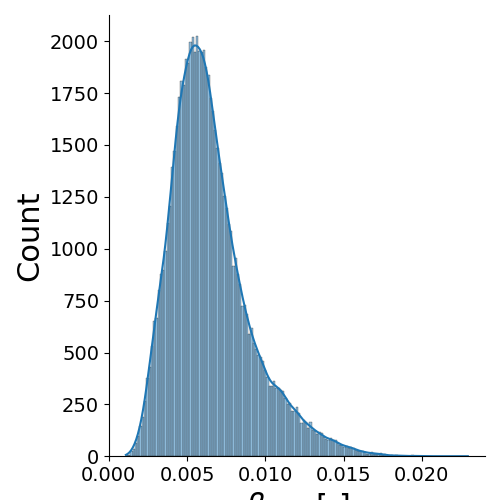

In [135]:
plt.close('all')
import seaborn as sns
# fig = plt.figure(figsize=(6, 6))
ax = sns.displot(approx_beta, kde=True)
ax.set(xlabel=r'$\beta_{ped}$ [-]')
plt.show()

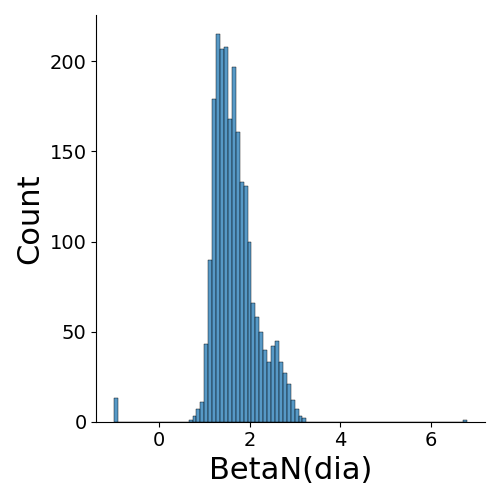

In [93]:
sns.displot(data = jet_pedestal_database, x=  'BetaN(dia)')

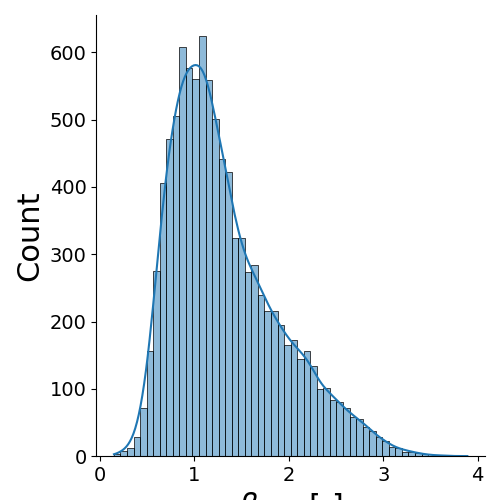

In [86]:
plt.close('all')
import seaborn as sns
# fig = plt.figure(figsize=(6, 6))
ax = sns.displot(approx_bpol, kde=True)
ax.set(xlabel=r'$B_{\theta}$ [T]')
plt.show()

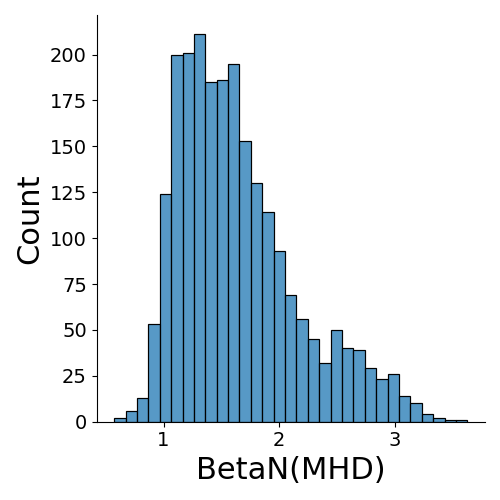

In [26]:
jet_pedestal_database.columns.to_list()

['Unnamed: 0',
 'shot',
 'dda',
 't1',
 't2',
 'Tepedheight(keV)',
 'error_Tepedheight(keV)',
 'nepedheight10^19(m^-3)',
 'error_nepedheight10^19(m^-3)',
 'pepedheight(kPa)',
 'error_pepedheight(kPa)',
 'TepsiN=0.9pre-ELM(keV)',
 'error_TepsiN=0.9pre-ELM(keV)',
 'nepsiN=0.9pre-ELM10^19(m^-3)',
 'error_nepsiN=0.9pre-ELM10^19(m^-3)',
 'pepsiN=0.9pre-ELM(kPa)',
 'error_pepsiN=0.9pre-ELM(kPa)',
 'Tepedestalwidth(psiN%)',
 'error_Tepedestalwidth(psiN%)',
 'Nepedestalwidth(psiN%)',
 'error_Nepedestalwidth(psiN%)',
 'pepedestalwidth(psiN%)',
 'error_pepedestalwidth(psiN%)',
 'TepedestalwidthRmid(cm)',
 'error_TepedestalwidthRmid(cm)',
 'NepedestalwidthRmid(cm)',
 'error_NepedestalwidthRmid(cm)',
 'pepedestalwidthRmid(cm)',
 'error_pepedestalwidthRmid(cm)',
 'neseparatrixfromexpdata10^19(m^-3)',
 'error_neseparatrixfromexpdata10^19(m^-3)',
 'neseparatrixfromfit10^19(m^-3)',
 'error_neseparatrixfromfit10^19(m^-3)',
 'neposition(psiN)',
 'error_neposition(psiN)',
 'Teposition(psiN)',
 'error_Tep